In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arrow
from scipy.signal import savgol_filter 
import numpy as np
from lmfit.models import SkewedGaussianModel

In [2]:
# data from: http://ncov.mohw.go.kr/
df = pd.read_csv("all.csv").loc[1:].reset_index()
df["counts"] = [float(c.replace(",", "")) for c in df["계(명)"]]
df["savgol"] = savgol_filter([float(c.replace(",", "")) for c in df["계(명)"]], 7, 2)
df["ts"] = pd.to_datetime([str(arrow.get(t)) for t in df["일자"]])
df["rolling_avg"] = df["counts"].rolling(7).mean()
df.tail()

,index,일자,계(명),계(명).1,해외유입(명),사망(명),counts,savgol,ts,rolling_avg
801,802,2022.4.1,"280,273","280,225",48,360,280273.0,309466.428571,2022-04-01 00:00:00+00:00,316284.714286
802,803,2022.4.2,"264,171","264,103",68,336,264171.0,234328.000000,2022-04-02 00:00:00+00:00,306088.428571
803,804,2022.4.3,"234,301","234,279",22,306,234301.0,210205.214286,2022-04-03 00:00:00+00:00,294120.142857
804,805,2022.4.4,"127,190","127,184",6,218,127190.0,205093.714286,2022-04-04 00:00:00+00:00,285548.857143
805,806,2022.4.5,"255,135","255,125",10,209,255135.0,218993.500000,2022-04-05 00:00:00+00:00,272350.571429


In [3]:
def skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=False):
    window_length = len(df) - start_idx
    april = pd.to_datetime([f"2022-04-{x}T00:00:00+00:00'" for x in range(1,31)]).to_list()
    may = pd.to_datetime([f"2022-05-{x}T00:00:00+00:00'" for x in range(1,32)]).to_list()
    whole_date = df["ts"].to_list() + april + may

    whole_date = sorted(list(set(whole_date)))
    xvals = np.arange(0, window_length)
    yvals = target_y[start_idx:]


    model = SkewedGaussianModel()

    # set initial parameter values
    params = model.make_params(amplitude=13639305., center=102.12, sigma=22.41, gamma=0)

    # adjust parameters  to best fit data.
    result = model.fit(yvals, params, x=xvals)
    
    if show_stats:
        print(result.fit_report())

    plt.figure(figsize=(6.5, 5))
    plt.title("fitting")
    plt.plot(xvals, yvals, 'd')
    ex = result.eval(x=xvals)
    plt.plot(xvals, ex)


    plt.figure(figsize=(10, 5))

    expected = result.eval(x=np.arange(-20, window_length+35))

    plt.plot(whole_date[start_idx-20:start_idx+window_length],  target_y[start_idx-20:], 'd', label="daily Covid cases")
    plt.plot(whole_date[start_idx-20:start_idx+window_length+35], expected, label="skewed gaussian fitting")
    plt.legend()
    plt.title("Forcasting Korean Covid cases")
    plt.xticks(whole_date[start_idx-20:start_idx+window_length+35][::15])

## 7-day rolling avg & original confirmed cases

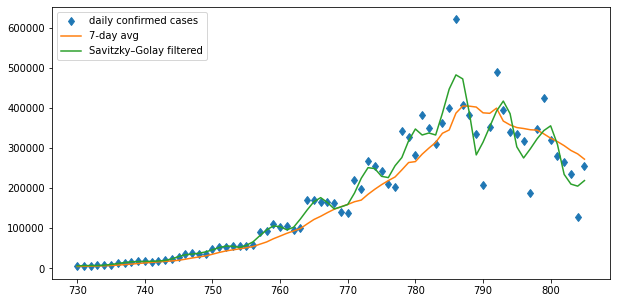

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df.counts[730:], 'd', label="daily confirmed cases")
df.rolling_avg[730:].plot(label="7-day avg")
df.savgol[730:].plot(label="Savitzky–Golay filtered")
plt.legend()

## skewed normal fifting using original data

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 180
    # data points      = 36
    # variables        = 4
    chi-square         = 1.8040e+11
    reduced chi-square = 5.6375e+09
    Akaike info crit   = 812.057496
    Bayesian info crit = 818.391571
[[Variables]]
    amplitude:  14154353.8 +/- 1181304.06 (8.35%) (init = 1.363930e+07)
    center:     18.6267549 +/- 176359.917 (946809.67%) (init = 102.12)
    sigma:      14.4597550 +/- 1384.44015 (9574.44%) (init = 22.41)
    gamma:     -0.00808197 +/- 15288.1254 (189163244.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(center, sigma)     = 1.000
    C(sigma, gamma)      = -1.000
    C(amplitude, gamma)  = 0.272
    C(amplitude, center) = -0.272
    C(amplitude, sigma)  = -0.271


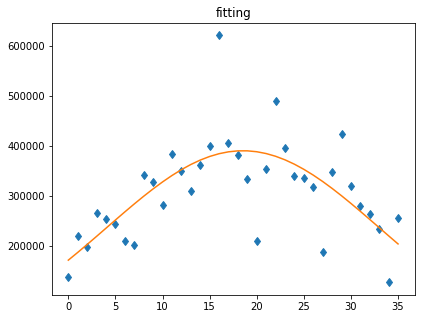

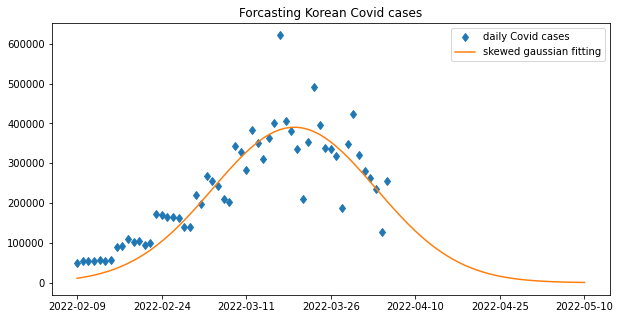

In [5]:
target_y = df.counts
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)
plt.savefig("./figs/fitting_n_prediction.png", facecolor="w")

## skewed normal fifting using 7-day rolling avg

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 235
    # data points      = 36
    # variables        = 4
    chi-square         = 8.4140e+09
    reduced chi-square = 2.6294e+08
    Akaike info crit   = 701.707019
    Bayesian info crit = 708.041095
[[Variables]]
    amplitude:  14578414.3 +/- 413926.593 (2.84%) (init = 1.363930e+07)
    center:     21.7963466 +/- 10291.2150 (47215.32%) (init = 102.12)
    sigma:      15.1608209 +/- 172.953185 (1140.79%) (init = 22.41)
    gamma:     -0.01833976 +/- 851.186132 (4641206.05%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(center, sigma)     = 1.000
    C(sigma, gamma)      = -1.000
    C(amplitude, gamma)  = 0.705
    C(amplitude, center) = -0.705
    C(amplitude, sigma)  = -0.703


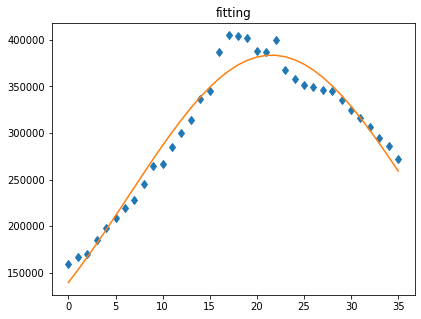

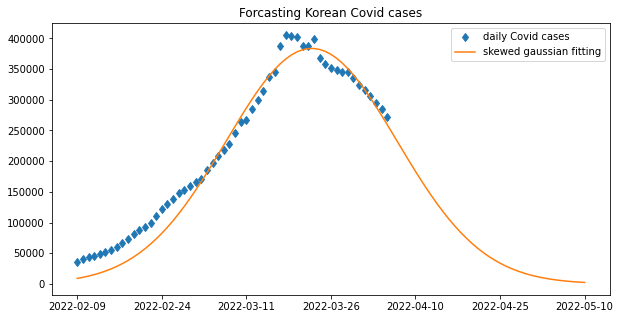

In [6]:
target_y = df.rolling_avg
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 184
    # data points      = 36
    # variables        = 4
    chi-square         = 6.7160e+10
    reduced chi-square = 2.0988e+09
    Akaike info crit   = 776.485773
    Bayesian info crit = 782.819849
[[Variables]]
    amplitude:  14192650.7 +/- 718894.820 (5.07%) (init = 1.363930e+07)
    center:     18.6578729 +/- 138053.722 (739922.09%) (init = 102.12)
    sigma:      14.5097435 +/- 956.759764 (6593.91%) (init = 22.41)
    gamma:     -0.00868763 +/- 11925.7823 (137273209.65%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(center, sigma)     = 1.000
    C(sigma, gamma)      = -1.000
    C(amplitude, gamma)  = 0.232
    C(amplitude, center) = -0.232
    C(amplitude, sigma)  = -0.231


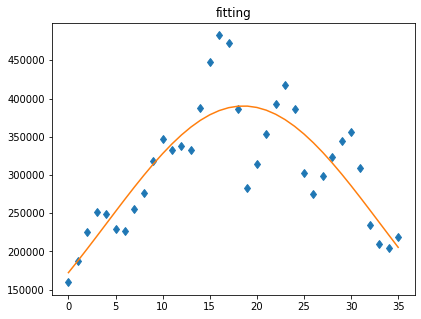

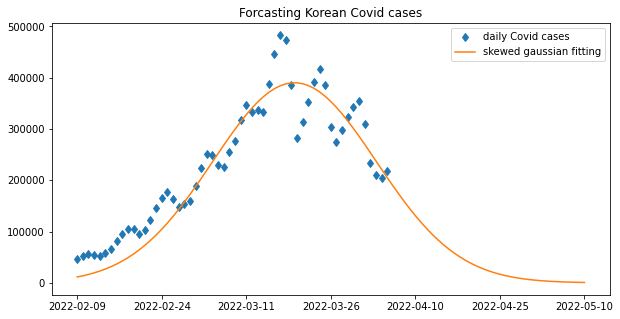

In [7]:
target_y = df.savgol
start_idx = 770

skewed_gaussian_fitting_n_plot(target_y, start_idx, df, show_stats=True)